# Projeto 15: Compactação de imagens com autoencoders

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 53.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Etapa 1: Importação das bibliotecas

In [2]:
from torchvision import datasets, transforms
import torch
from torch import nn,optim
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [4]:
data_train = datasets.MNIST('MNIST-data', train=True, download = True,
                            transform = transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(data_train, batch_size = 256,
                                           shuffle = True)

Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw
Processing...
Done!


In [5]:
data_test = datasets.MNIST('MNIST-data', train = False, download = True,
                           transform = transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(data_test, batch_size = 256,
                                         shuffle = True)

## Etapa 3: Construção do autoencoder

In [11]:
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.dense0 = nn.Linear(in_features = 784, out_features=32)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(32, 784)
    self.activation1 = nn.Sigmoid()

  def forward(self, X):
    X = X.view(-1, 28*28)
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dense1(X)
    X = self.activation1(X)
    return X

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [13]:
model = autoencoder()
model.to(device)

autoencoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=32, out_features=784, bias=True)
  (activation1): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

## Etapa 4: Treinamento do modelo

In [17]:
for epoch in range(20):

  # Treinamento
  running_loss_train = 0
  
  for data in loader_train:
    model.train()
    inputs, _ = data
    inputs = inputs.to(device)
    optimizer.zero_grad()

    outputs = model.forward(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    loss.backward()
    optimizer.step()
    running_loss_train += loss.item()

  # Validação
  running_loss_val = 0
  
  for data in loader_val:
    model.eval()
    inputs, _ = data
    inputs = inputs.to(device)

    outputs = model.forward(inputs)
    loss = criterion(outputs, inputs.view(*outputs.shape))
    running_loss_val += loss.item()

  # FINAL DA ÉPOCA
  print('Época {:3d}: perda_train {:.5f} perda_val {:.5f}' \
        .format(epoch+1, running_loss_train/len(loader_train), running_loss_val/len(loader_val)))


Época   1: perda_train 0.15518 perda_val 0.14615
Época   2: perda_train 0.14136 perda_val 0.13489
Época   3: perda_train 0.13225 perda_val 0.12713
Época   4: perda_train 0.12559 perda_val 0.12130
Época   5: perda_train 0.12049 perda_val 0.11703
Época   6: perda_train 0.11690 perda_val 0.11420
Época   7: perda_train 0.11431 perda_val 0.11198
Época   8: perda_train 0.11256 perda_val 0.11049
Época   9: perda_train 0.11133 perda_val 0.10941
Época  10: perda_train 0.11056 perda_val 0.10867
Época  11: perda_train 0.11005 perda_val 0.10823
Época  12: perda_train 0.10969 perda_val 0.10748
Época  13: perda_train 0.10941 perda_val 0.10738
Época  14: perda_train 0.10919 perda_val 0.10792
Época  15: perda_train 0.10886 perda_val 0.10628
Época  16: perda_train 0.10726 perda_val 0.10539
Época  17: perda_train 0.10683 perda_val 0.10534
Época  18: perda_train 0.10667 perda_val 0.10494
Época  19: perda_train 0.10653 perda_val 0.10487
Época  20: perda_train 0.10644 perda_val 0.10492


## Etapa 5: Geração do encoder

In [37]:
list(model.children())

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=784, bias=True),
 Sigmoid()]

In [25]:
list(model.children())[0], list(model.children())[1]

(Linear(in_features=784, out_features=32, bias=True), ReLU())

In [41]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.dense0 = list(model.children())[0]
    self.activation0 = list(model.children())[1]

  def forward(self, X):
    X = X.view(-1, 28*28)
    X = self.dense0(X)
    X = self.activation0(X)
    return X

In [42]:
model_enc = encoder()
model_enc.to(device)

encoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
)

## Etapa 6: Geração do decoder

In [43]:
list(model.children())[2], list(model.children())[3]

(Linear(in_features=32, out_features=784, bias=True), Sigmoid())

In [44]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.dense0 = list(model.children())[2]
    self.activation0 = list(model.children())[3]

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    return X

In [45]:
model_dec = decoder()
model_dec.to(device)

decoder(
  (dense0): Linear(in_features=32, out_features=784, bias=True)
  (activation0): Sigmoid()
)

## Etapa 7: Visualização dos resultados

In [47]:
num_img = 10
img_test = next(iter(loader_val))[0][:num_img]
img_test = img_test.to(device)

In [48]:
img_test.shape

torch.Size([10, 1, 28, 28])

In [49]:
model_enc.eval()
img_cod = model_enc(img_test)

In [50]:
img_cod.shape

torch.Size([10, 32])

In [51]:
model_dec.eval()
img_dec = model_dec(img_cod)

In [52]:
img_dec.shape

torch.Size([10, 784])

In [53]:
img_test = img_test.detach().cpu().numpy().reshape(-1, 28, 28)

In [54]:
img_cod = img_cod.detach().cpu().numpy().reshape(-1,8,4)
img_dec = img_dec.detach().cpu().numpy().reshape(-1,28,28)

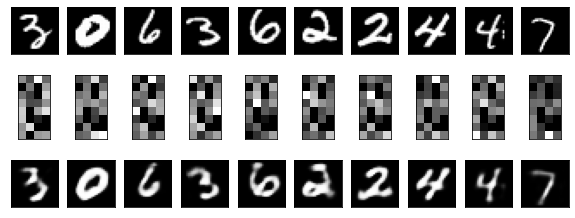

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=num_img, figsize=(10,4))
for images, ax_row in zip([img_test, img_cod, img_dec], axes):
  for img, ax in zip(images, ax_row):
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)